In [1]:
import torch, PIL
from utils.inference_utils  import *

/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, img_transform, tokenizer, post_processor = torch.hub.load(".", 'base_model', source="local")

/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a mo

In [3]:
device = "cuda"
img = PIL.Image.open("sample.jpg")
caption = "three<mask>in a room"
model = model.to(device)
imgs_tensor = img_transform(img).to(device).unsqueeze(0)
tokens_tensor = tokenizer(caption, return_tensors="pt").to(device)
outputs = model(imgs_tensor, tokens_tensor, one_pass=True)

In [4]:
# decode caption
print(outputs['mlm_logits'].shape)
print(f"Predicted caption: {tokenizer.decode(outputs['mlm_logits'][0].argmax(-1))}")

torch.Size([1, 7, 50265])
Predicted caption: .three women in a room.


In [5]:
# decode references
probas = 1 - outputs['pred_logits'].float().softmax(-1)[0, :, -1].cpu()
keep = (probas > 0.7).cpu()
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].float()[0, keep].cpu(), img.size)
positive_tokens = (outputs["pred_logits"].float()[0, keep].softmax(-1).cpu() > 0.1).nonzero().tolist()
predicted_spans = defaultdict(str)
for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = outputs["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

In [6]:
def plot_results(pil_img, scores, boxes, labels, masks=None):
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],[0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

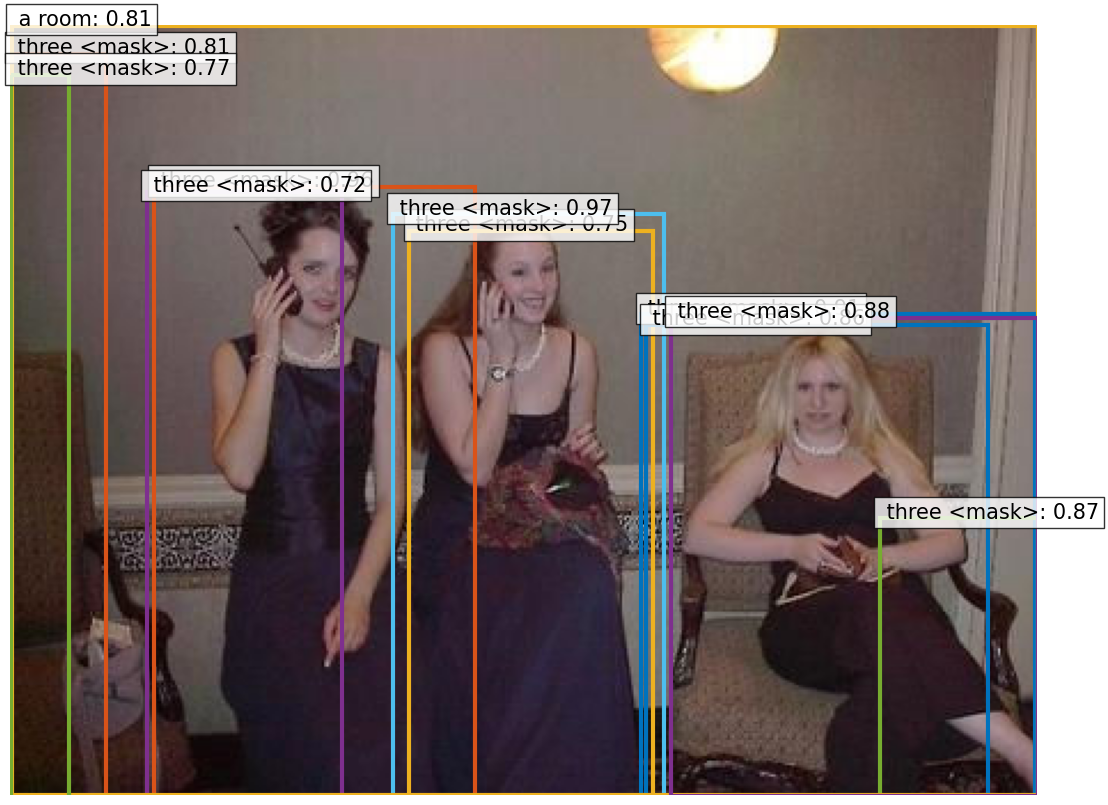

In [7]:
labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
plot_results(img, probas[keep], bboxes_scaled, labels)

In [8]:
    interested_bboxs  = rescale_bboxes(model_outputs['pred_boxes'].float().cpu()[0, most_confident_raw_idx:most_confident_raw_idx+1], dp['text_info']['img_size']).to(device)


NameError: name 'model_outputs' is not defined

In [ ]:
keep

tensor([False, False, False, False, False, False, False, False, False,  True,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False,  True])

In [ ]:
outputs

In [10]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}